# <center> New York Taxi Prediction Modeling </center>

**Business Goal**:
Determine the features and use them to predict the duration of taxi trip in New York City

**Technical Task**:
Build up the Machine Learning Model that, based on the proposed features, will predict a numerical feature - taxi ride time, that is, solve a regression problem.

For this contest the evaluation metric is the Root Mean Squared Log Error.

**Main Steps**:

1. Create a data set based on multiple sources of information;

2. Design new features using Feature Engineering and identify the most significant ones to be used for the building the model;

3. Explore the provided data and identify patterns;

4. Build several models and select the one that shows the best result for a given metric;

5. Design a process for predicting trip duration for new data.

## Basic Analysis and Data Extension

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [2]:
taxi_data = pd.read_csv('DATA/Project5_train_data.zip', compression = 'zip')
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [3]:
# convert 'object' type into datetime format
# create new features

taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')

def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.normalize()
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.strftime('%A')
    return df

taxi_data = add_datetime_features(taxi_data)

In [4]:
# identify and add information about public holidays

holiday_data = pd.read_csv('DATA/holiday_data.csv', sep = ';')

def add_holiday_features(df_1, df_2):
    df_2.date = pd.to_datetime(df_2.date, format = '%Y-%m-%d')
    df_2.date = df_2.date.dt.normalize()
    df_1['pickup_holiday'] = df_1['pickup_date'].apply(lambda x: 1 if x in df_2['date'].values else 0)
    return df_1

taxi_data = add_holiday_features(taxi_data, holiday_data)

In [5]:
# add features from Open Source Routing Machine (OSRM) data

osrm_data = pd.read_csv('DATA/osrm_data_train.zip', compression = 'zip')

def add_osrm_features(df_1, df_2):
    df_2.drop(['starting_street', 'end_street', 'street_for_each_step', 'distance_per_step',
              'travel_time_per_step', 'step_maneuvers', 'step_direction', 'step_location_list'],
             inplace = True, axis = 1)
    df_1 = df_1.merge(df_2, on = 'id', how = 'left')
    return df_1

taxi_data = add_osrm_features(taxi_data, osrm_data)

In [6]:
# calculating distance by Haversine formula and angel of trip direction

def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))     # convert angels into radians
    EARTH_RADIUS = 6371                                                    # Earth radius
    
    lat_delta = lat2 - lat1                                           # shortest distance h by Haversine formula
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))      # convert angels into radians
    
    lng_delta_rad = lng2 - lng1                                             # direction angel of movement alpha
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [7]:
# creating new features

def add_geographical_features(df):
    df['haversine_distance'] = get_haversine_distance(df.pickup_latitude,
                                                     df.pickup_longitude,
                                                     df.dropoff_latitude,
                                                     df.dropoff_longitude)
    df['direction'] = get_angle_direction(df.pickup_latitude,
                                                     df.pickup_longitude,
                                                     df.dropoff_latitude,
                                                     df.dropoff_longitude)
    return df

taxi_data = add_geographical_features(taxi_data)

In [8]:
# clustering using KMeans algorithm

coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']], 
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

kmeans = cluster.KMeans(n_clusters = 10, random_state = 42)
kmeans.fit(coords)

def add_cluster_features(df, model):
    df['geo_cluster'] = model.predict(df[['pickup_latitude', 'pickup_longitude',
                                         'dropoff_latitude', 'dropoff_longitude']])
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [9]:
# weather features

weather_data = pd.read_csv('DATA/weather_data.zip', compression = 'zip')

weather_data.drop(['time', 'windchill', 'heat index', 'humidity', 'pressure',
                  'dew Point', 'wind dir', 'gust speed', 'conditions'],
                 inplace = True, axis = 1)

weather_data['date'] = pd.to_datetime(weather_data.date)

def add_weather_features(df_1, df_2):
    df_1 = df_1.merge(df_2, how = 'left', left_on = ['pickup_date', 'pickup_hour'],
                     right_on = ['date', 'hour'])
    
    df_1.drop(['date', 'hour'], inplace = True, axis = 1)
    
    return df_1

taxi_data = add_weather_features(taxi_data, weather_data)

In [10]:
# checking null rows and columns

taxi_data.isnull().sum()

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_date                 0
pickup_hour                 0
pickup_day_of_week          0
pickup_holiday              0
total_distance              1
total_travel_time           1
number_of_steps             1
haversine_distance          0
direction                   0
geo_cluster                 0
temperature             12032
visibility              12032
wind speed              12032
precip                  12032
events                1387217
dtype: int64

In [11]:
def fill_null_weather_data(df):
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_cols:
        df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))
    
    df['events'] = df['events'].fillna('None')

    values = {'total_distance' : df.total_distance.median(),
             'total_travel_time' : df.total_travel_time.median(),
             'number_of_steps' : df.number_of_steps.median()}
    df = df.fillna(values)
    
    return df

taxi_data = fill_null_weather_data(taxi_data)

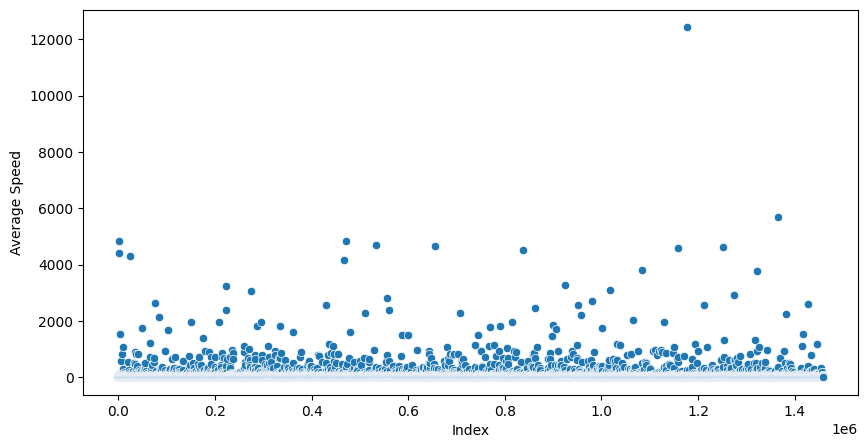

In [12]:
# review outliers

avg_speed = taxi_data.total_distance / taxi_data.trip_duration * 3.6

fig, ax = plt.subplots(figsize = (10, 5))
sns.scatterplot(x = avg_speed.index, y = avg_speed, ax = ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average Speed');

In [13]:
# delete outliers

mask1 = taxi_data.trip_duration >= 86400
mask2 = avg_speed >= 300

taxi_data.drop(taxi_data[mask1].index, inplace = True)
taxi_data.drop(taxi_data[mask2].index, inplace = True)

/var/folders/hn/jxm_2f5n1xz5scjw_l_39vzh0000gn/T/ipykernel_3462/3412011323.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_data.drop(taxi_data[mask2].index, inplace = True)


## Exploratory Data Analysis

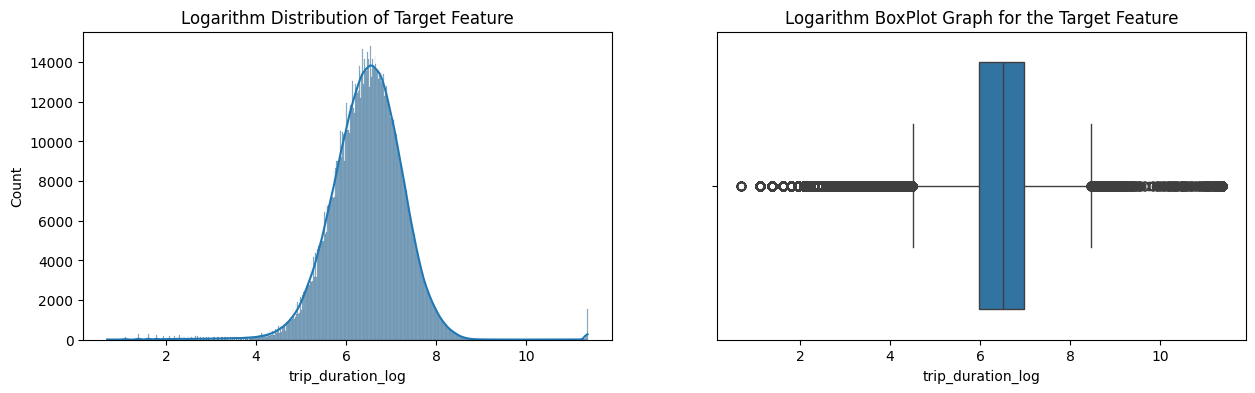

In [14]:
taxi_data['trip_duration_log'] = np.log(taxi_data.trip_duration + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

histplot = sns.histplot(taxi_data, x = 'trip_duration_log', kde = True, ax = ax[0])
histplot.set_title('Logarithm Distribution of Target Feature')

boxplot = sns.boxplot(taxi_data, x = 'trip_duration_log', ax = ax[1])
boxplot.set_title('Logarithm BoxPlot Graph for the Target Feature');

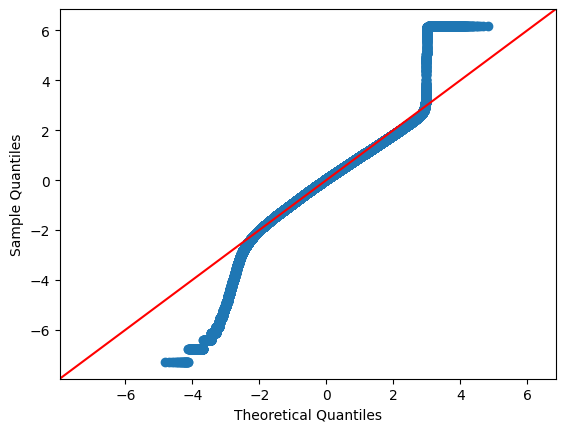

In [15]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt

qqplot(taxi_data['trip_duration_log'], line = '45', fit = True)

plt.show();

In [16]:
H0 = 'Data distributed normaly'
H1 = 'Data distributed abnormaly'

alpha = 0.05

_, p = stats.normaltest(taxi_data.trip_duration_log)

print(p)

if p > alpha / 2:
    print(H0)
else:
    print(H1)

0.0
Data distributed abnormaly


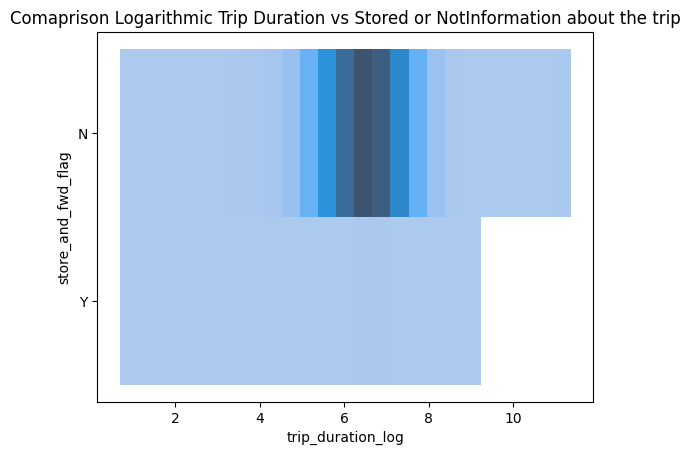

In [17]:
sns.histplot(data = taxi_data, x = 'trip_duration_log',
             y = 'store_and_fwd_flag', bins = 25, kde = True)
plt.title('Comaprison Logarithmic Trip Duration vs Stored or NotInformation about the trip');

#### Conclusion

Distribution within the groups differs significantly, threfore the feature 'store_and_fwd_flag' has an impact while calculating the taxi trip duration.

In [ ]:
fig = px.histogram(taxi_data, x = 'pickup_hour',
                   title = 'Number of Trips distribution depending on Pick-up Hour')
fig.show()
fig.write_html('Plotly_Graphs/fig_1.html')

#### Conclusion

The highest number of taxi orders is happening between 18:00 and 19:00 hour. The lowest number of orders is taking place between 01:00 and 06:00 hour in the morning.

In [ ]:
group = taxi_data.groupby(['pickup_hour'])['trip_duration'].median()

fig = px.bar(group, title = 'Dependence between Median Trip Duration and Pick-up hour')
fig.show()
fig.write_html('Plotly_Graphs/fig_2.html')

#### Conclusion

Peak of the median duration trip is happaning between 11:00 and 15:00. The fastest trips are taking place at around 06:00 in the morning.

In [ ]:
fig = px.histogram(taxi_data, x = 'pickup_day_of_week',
            title = 'Number of Trips distribution depending on the day of week')
fig.show()
fig.write_html('Plotly_Graphs/fig_3.html')

#### Conclusion

The most trips are happening on Saturday and Friday. The least - on Monday.

In [ ]:
group = taxi_data.groupby(['pickup_day_of_week'])['trip_duration'].median()

fig = px.bar(group, title = 'Dependence of the median trip duration on the day of the week')
fig.show()
fig.write_html('Plotly_Graphs/fig_4.html')

#### Conclusion

The shortest median duration trip is taking place on Sunday. The longest - Thursday.

In [ ]:
table = pd.pivot_table(taxi_data, index = 'pickup_hour',
               columns = 'pickup_day_of_week',
               values = 'trip_duration',
               aggfunc = 'median')
heatmap = sns.heatmap(data = table, cmap = 'coolwarm');

#### Conclusion

The longest trips - in median terms - are observed from Monday to Friday between 8:00 in the morning and 18:00 in the afternoon. The longest median trip duration was observed on Thursday at 14:00.

In [ ]:
fig = px.scatter(taxi_data, x = 'pickup_longitude',
                 y = 'pickup_latitude', 
                 color = 'geo_cluster')
xmin = -74.03
xmax = -73.75

ymin = 40.63
ymax = 40.85

fig.update_xaxes(range = [xmin, xmax])
fig.update_yaxes(range = [ymin, ymax], autorange = False)
fig.update_traces(marker_size=1)

fig.show()

In [ ]:
fig = px.scatter(taxi_data, x = 'dropoff_longitude',
                 y = 'dropoff_latitude', 
                 color = 'geo_cluster')
xmin = -74.03
xmax = -73.75

ymin = 40.63
ymax = 40.85

fig.update_xaxes(range = [xmin, xmax])
fig.update_yaxes(range = [ymin, ymax], autorange = False)
fig.update_traces(marker_size=1)

fig.show()

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, axes = plt.subplots(1, 2, figsize = (20, 8))

sns.scatterplot(taxi_data,
               x = 'pickup_longitude',
               y = 'pickup_latitude',
               hue = 'geo_cluster',
               s = 1,
               ax = axes[0],
               palette = 'rainbow')
axes[0].set_xlim(city_long_border)
axes[0].set_ylim(city_lat_border)
axes[0].set_title('Geographic location of Pick-up points')
axes[0].legend(loc = 'lower right');

sns.scatterplot(taxi_data,
               x = 'dropoff_longitude',
               y = 'dropoff_latitude',
               hue = 'geo_cluster',
               s = 1,
               ax = axes[1],
               palette = 'bright')
axes[1].set_xlim(city_long_border)
axes[1].set_ylim(city_lat_border)
axes[1].set_title('Geographic location of Drop-off points')
axes[1].legend(loc = 'lower right');

#### Conclusion

Two clusters are located outside of New York City.

## Features Selection and Transformation

In [22]:
train_data = taxi_data.copy()

In [23]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data.drop(drop_columns, inplace = True, axis = 1)

train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

one_hot_encoder = preprocessing.OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns = column_names)

train_data = pd.concat([train_data.reset_index(drop = True).drop(columns_to_change, axis = 1), data_onehot],
                       axis = 1)

print('Shape of Data: {}'.format(train_data.shape))

Shape of Data: (1458233, 38)


In [24]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis = 1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size = 0.33,
    random_state = 42
)

In [25]:
# select features for the modeling

selector = feature_selection.SelectKBest(score_func = feature_selection.f_regression, k = 25)
selector.fit(X_train, y_train_log)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

print('Top 25 features: \n', best_features)

Top 25 features: 
 ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_4'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_8']


In [26]:
# scaling data

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_scaled = pd.DataFrame(X_train, columns = best_features)
X_valid_scaled = pd.DataFrame(X_valid, columns = best_features)

## Machine Learning Models

In [27]:
# Linear Regression

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)

y_train_pred = lr_model.predict(X_train_scaled)
y_valid_pred = lr_model.predict(X_valid_scaled)

rmsle_train = round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3)
rmsle_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3)

print('RMSLE metric on train sample: {}'.format(rmsle_train))
print('RMSLE metric on valid sample: {}'.format(rmsle_valid))

RMSLE metric on train sample: 0.534
RMSLE metric on valid sample: 0.536


In [28]:
# Linear Regression on Polynomial Features

poly = preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train_log)

y_train_poly_pred = lr_poly.predict(X_train_poly)
y_valid_poly_pred = lr_poly.predict(X_valid_poly)

rmsle_train = round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly_pred)), 3)
rmsle_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred)), 3)

print('RMSLE metric on polynomial features train sample: {}'.format(rmsle_train))
print('RMSLE metric on polynomial features valid sample: {}'.format(rmsle_valid))

RMSLE metric on polynomial features train sample: 0.467
RMSLE metric on polynomial features valid sample: 0.613


In [29]:
# Linear Regression with Ridge Regularization

lr_ridge = linear_model.Ridge(alpha = 1)
lr_ridge.fit(X_train_poly, y_train_log)

y_train_ridge_pred = lr_ridge.predict(X_train_poly)
y_valid_ridge_pred = lr_ridge.predict(X_valid_poly)

rmsle_train = round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_ridge_pred)), 3)
rmsle_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_ridge_pred)), 3)

print('RMSLE metric on train sample: {}'.format(rmsle_train))
print('RMSLE metric on valid sample: {}'.format(rmsle_valid))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.07005e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RMSLE metric on train sample: 0.469
RMSLE metric on valid sample: 0.475


Best Max Depth parameter: 12
RMSLE metric on train sample: 0.406
RMSLE metric on valid sample: 0.43


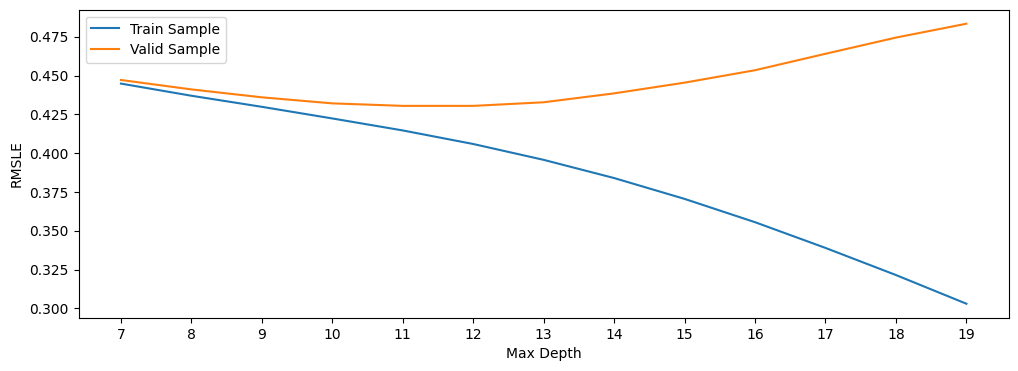

In [30]:
# Decision Tree

max_depths = range(7, 20)

train_scores = []
valid_scores = []

for depth in max_depths:
    dtreg = tree.DecisionTreeRegressor(max_depth = depth, random_state = 42)
    dtreg.fit(X_train_scaled, y_train_log)
    
    y_train_dtreg_pred = dtreg.predict(X_train_scaled)
    y_valid_dtreg_pred = dtreg.predict(X_valid_scaled)

    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_dtreg_pred)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_dtreg_pred)))

# Visualization of RMSLE metric depending on Max Depth parameter in Decision Tree Regressor Model

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(max_depths, train_scores, label = 'Train Sample')
ax.plot(max_depths, valid_scores, label = 'Valid Sample')
ax.set_xlabel('Max Depth')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depths)
ax.legend();

best_index = valid_scores.index(min(valid_scores))
print('Best Max Depth parameter:', max_depths[best_index])
print('RMSLE metric on train sample:', round(train_scores[best_index], 3))
print('RMSLE metric on valid sample:', round(valid_scores[best_index], 3))

In [31]:
# Random Forest Regressor

rfreg = ensemble.RandomForestRegressor(n_estimators = 200,
                                      max_depth = 12,
                                      criterion = 'squared_error',
                                      min_samples_split = 20,
                                      random_state = 42,
                                      verbose = True)

rfreg.fit(X_train_scaled, y_train_log)

y_train_rfreg_pred = rfreg.predict(X_train_scaled)
y_valid_rfreg_pred = rfreg.predict(X_valid_scaled)

rmsle_train = round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_rfreg_pred)), 3)
rmsle_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_rfreg_pred)), 3)

print('RMSLE metric on train sample: {}'.format(rmsle_train))
print('RMSLE metric on valid sample: {}'.format(rmsle_valid))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 34.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   23.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s


RMSLE metric on train sample: 0.399
RMSLE metric on valid sample: 0.414


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.4s


In [32]:
# Gradient Boosting Regressor

gbreg = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                          n_estimators = 100,
                                          max_depth = 6,
                                          min_samples_split = 30,
                                          random_state = 42,
                                          verbose = True)
gbreg.fit(X_train_scaled, y_train_log)

y_train_gbreg_pred = gbreg.predict(X_train_scaled)
y_valid_gbreg_pred = gbreg.predict(X_valid_scaled)

rmsle_train = round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_gbreg_pred)), 3)
rmsle_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_gbreg_pred)), 3)

print('RMSLE metric on train sample: {}'.format(rmsle_train))
print('RMSLE metric on valid sample: {}'.format(rmsle_valid))

      Iter       Train Loss   Remaining Time 
         1           0.3110           15.32m
         2           0.2247           15.07m
         3           0.1985           15.00m
         4           0.1872           14.59m
         5           0.1808           14.21m
         6           0.1774           13.87m
         7           0.1747           13.60m
         8           0.1723           13.35m
         9           0.1710           13.09m
        10           0.1697           12.86m
        20           0.1586           11.01m
        30           0.1524            9.44m
        40           0.1498            8.01m
        50           0.1469            6.66m
        60           0.1450            5.28m
        70           0.1427            3.95m
        80           0.1413            2.61m
        90           0.1397            1.30m
       100           0.1382            0.00s
RMSLE metric on train sample: 0.372
RMSLE metric on valid sample: 0.393


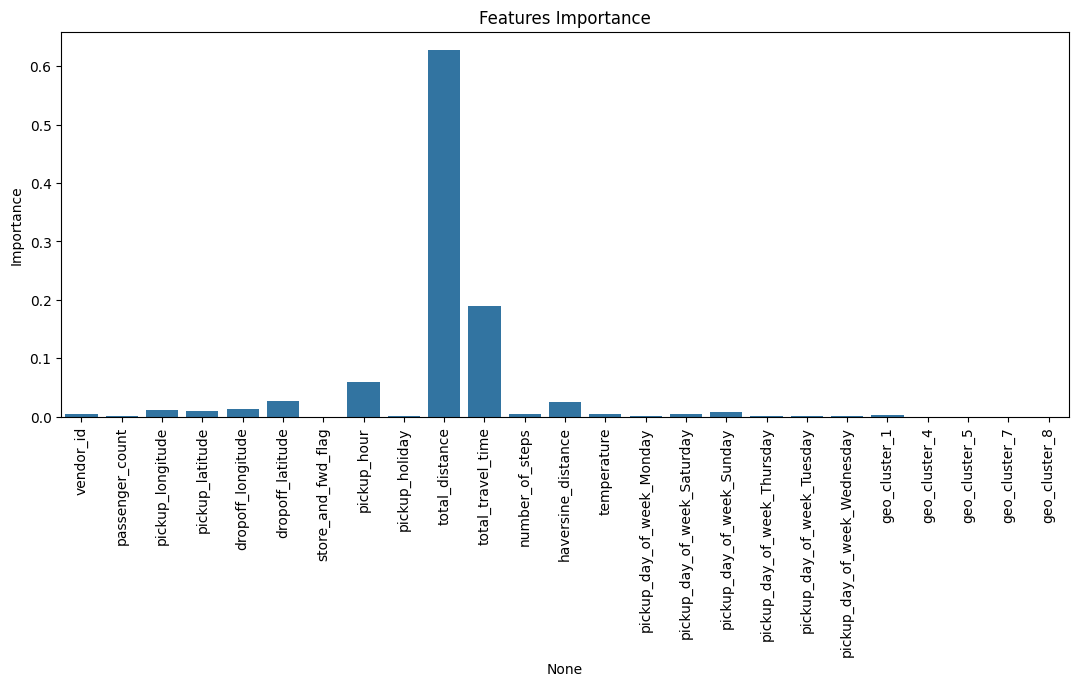

In [33]:
# Feature Importance

features = X_train.columns
importances = gbreg.feature_importances_

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = features, y = importances, ax = ax)
ax.set_title('Features Importance')
ax.set_ylabel('Importance')
ax.xaxis.set_tick_params(rotation = 90)

In [34]:
# Median Absolut Error to have more transparent result

y_valid_exp = np.exp(y_valid_log) - 1
y_valid_gbreg_pred_exp = np.exp(y_valid_gbreg_pred) - 1

meae_valid = metrics.median_absolute_error(y_valid_exp, y_valid_gbreg_pred_exp)

print('MeAE on validating sample', round(meae_valid / 60, 1), 'minutes')

MeAE on validating sample 1.8 minutes


## XGBoost (Extreme Gradient Boosting) on train and test data

In [35]:
# test data update

test_data = pd.read_csv('DATA/Project5_test_data.zip', compression = 'zip')
osrm_data_test = pd.read_csv('DATA/Project5_osrm_data_test.zip', compression = 'zip')
test_id = test_data['id']

test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')

test_data = (test_data
             .pipe(add_datetime_features)
             .pipe(add_holiday_features, df_2 = holiday_data)
             .pipe(add_osrm_features, df_2 = osrm_data_test)
             .pipe(add_geographical_features)
             .pipe(add_cluster_features, model = kmeans)
             .pipe(add_weather_features, df_2 = weather_data)
             .pipe(fill_null_weather_data))

test_data['vendor_id'] = test_data.vendor_id.apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data.store_and_fwd_flag.apply(lambda x: 0 if x == 'N' else 1)

test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns = column_names)
test_data = pd.concat([test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
                      axis=1)

X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


[0]	train-rmse:0.74025	valid-rmse:0.74223
[10]	train-rmse:0.49111	valid-rmse:0.49369
[20]	train-rmse:0.44049	valid-rmse:0.44336
[30]	train-rmse:0.42625	valid-rmse:0.42928
[40]	train-rmse:0.41886	valid-rmse:0.42206
[50]	train-rmse:0.41341	valid-rmse:0.41693
[60]	train-rmse:0.40903	valid-rmse:0.41286
[70]	train-rmse:0.40626	valid-rmse:0.41034
[80]	train-rmse:0.40359	valid-rmse:0.40804
[90]	train-rmse:0.40171	valid-rmse:0.40644
[100]	train-rmse:0.39963	valid-rmse:0.40465
[110]	train-rmse:0.39805	valid-rmse:0.40332
[120]	train-rmse:0.39707	valid-rmse:0.40253
[130]	train-rmse:0.39587	valid-rmse:0.40161
[140]	train-rmse:0.39463	valid-rmse:0.40062
[150]	train-rmse:0.39357	valid-rmse:0.39982
[160]	train-rmse:0.39265	valid-rmse:0.39916
[170]	train-rmse:0.39179	valid-rmse:0.39855
[180]	train-rmse:0.39076	valid-rmse:0.39781
[190]	train-rmse:0.38970	valid-rmse:0.39710
[200]	train-rmse:0.38903	valid-rmse:0.39682
[210]	train-rmse:0.38821	valid-rmse:0.39625
[220]	train-rmse:0.38735	valid-rmse:0.39565

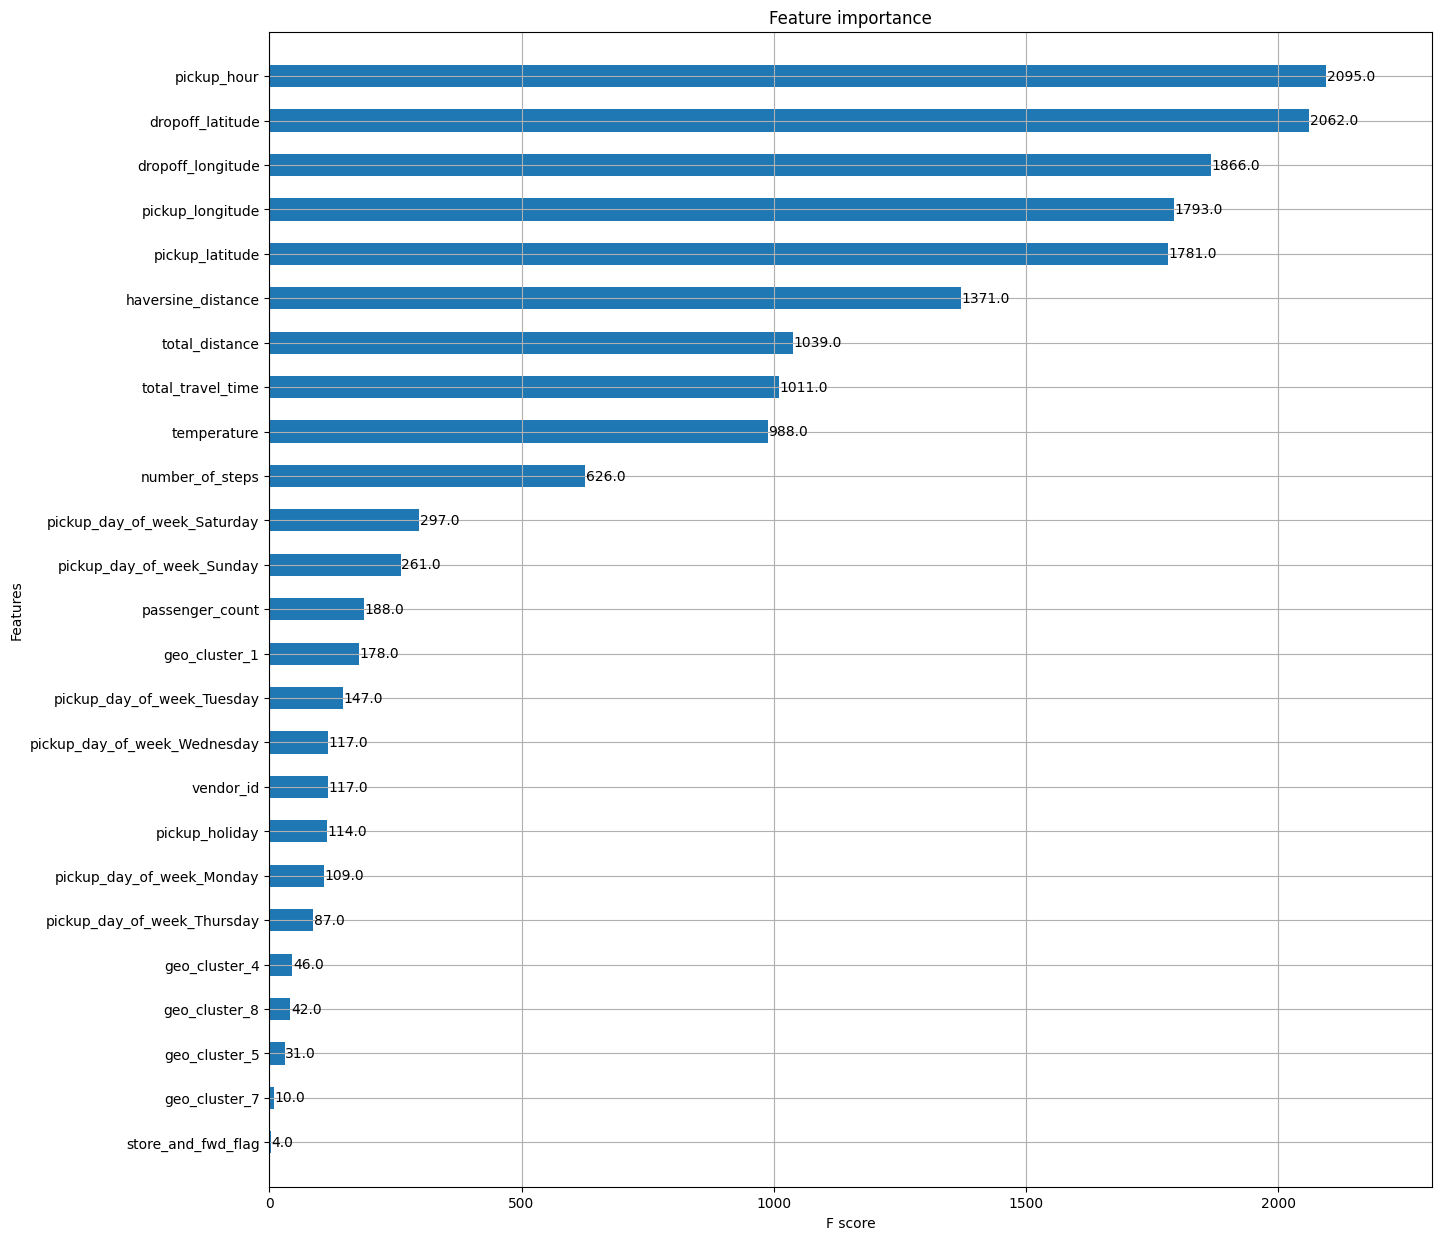

In [38]:
# create the matrix in DMatrix format

dtrain = xgb.DMatrix(X_train_scaled, label = y_train_log, feature_names = best_features.tolist())
dvalid = xgb.DMatrix(X_valid_scaled, label = y_valid_log, feature_names = best_features.tolist())
dtest = xgb.DMatrix(X_test_scaled, feature_names = best_features.tolist())

xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(
    params=xgb_pars, 
    dtrain=dtrain, 
    num_boost_round=300, 
    evals=watchlist, 
    early_stopping_rounds=20, 
    maximize=False, 
    verbose_eval=10 
)

y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5);